About Data:

---

| Column                         | Meaning                                                                                                     |
| ------------------------------ | ----------------------------------------------------------------------------------------------------------- |
| **ID**                         | Customer ID (just an identifier, not useful for prediction)                                                 |
| **LIMIT\_BAL**                 | Credit limit — maximum amount the person can borrow on their card                                           |
| **SEX**                        | Gender (1 = male, 2 = female)                                                                               |
| **EDUCATION**                  | Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others)                          |
| **MARRIAGE**                   | Marital status (1 = married, 2 = single, 3 = others)                                                        |
| **AGE**                        | Age in years                                                                                                |
| **PAY\_0**                     | Repayment status in September (0 = paid on time, 1 = 1 month late, 2 = 2 months late, -1 = paid in advance) |
| **PAY\_2**                     | Repayment status in August                                                                                  |
| **PAY\_3**                     | Repayment status in July                                                                                    |
| **PAY\_4**                     | Repayment status in June                                                                                    |
| **PAY\_5**                     | Repayment status in May                                                                                     |
| **PAY\_6**                     | Repayment status in April                                                                                   |
| **BILL\_AMT1**                 | Amount of bill in September                                                                                 |
| **BILL\_AMT2**                 | Amount of bill in August                                                                                    |
| **BILL\_AMT3**                 | Amount of bill in July                                                                                      |
| **BILL\_AMT4**                 | Amount of bill in June                                                                                      |
| **BILL\_AMT5**                 | Amount of bill in May                                                                                       |
| **BILL\_AMT6**                 | Amount of bill in April                                                                                     |
| **PAY\_AMT1**                  | Amount paid in September                                                                                    |
| **PAY\_AMT2**                  | Amount paid in August                                                                                       |
| **PAY\_AMT3**                  | Amount paid in July                                                                                         |
| **PAY\_AMT4**                  | Amount paid in June                                                                                         |
| **PAY\_AMT5**                  | Amount paid in May                                                                                          |
| **PAY\_AMT6**                  | Amount paid in April                                                                                        |
| **default payment next month** | Target variable — 1 = will default, 0 = will not default                                                    |

---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

In [ ]:
# --- 1. Load and clean ---
url = "https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/TestDrive-Datasets/UCI_Credit_Card.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.lower().str.replace(r"[\. ]+", "_", regex=True)
target = "default_payment_next_month"

df.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.sample(1)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
4289,4290,100000,1,2,1,52,0,0,0,0,...,66777,68176,69547,4611,4000,2387,2472,2502,2544,0


In [ ]:
df.shape

(30000, 25)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   id                          30000 non-null  int64
 1   limit_bal                   30000 non-null  int64
 2   sex                         30000 non-null  int64
 3   education                   30000 non-null  int64
 4   marriage                    30000 non-null  int64
 5   age                         30000 non-null  int64
 6   pay_0                       30000 non-null  int64
 7   pay_2                       30000 non-null  int64
 8   pay_3                       30000 non-null  int64
 9   pay_4                       30000 non-null  int64
 10  pay_5                       30000 non-null  int64
 11  pay_6                       30000 non-null  int64
 12  bill_amt1                   30000 non-null  int64
 13  bill_amt2                   30000 non-null  int64
 14  bill_a

In `PAY_X` columns:

* **-1** → Paid in advance (before due date)
* **0** → Paid on time
* **1** → 1 month late
* **2** → 2 months late
* **3, 4, 5, 6…** → Corresponding months late
  Higher numbers mean worse payment delays.


In [ ]:
# --- 2. Basic cleanup ---
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)


In [ ]:
# Most recent month → September 2005  → PAY_0
# 1 month earlier   → August 2005     → PAY_2
# 2 months earlier  → July 2005       → PAY_3
# 3 months earlier  → June 2005       → PAY_4
# 4 months earlier  → May 2005        → PAY_5
# 5 months earlier  → April 2005      → PAY_6


In [ ]:
# Count defaults (1) and non-defaults (0)
counts = df["default_payment_next_month"].value_counts()

# Calculate percentages
percentages = df["default_payment_next_month"].value_counts(normalize=True) * 100

print("Counts:\n", counts)
print("\nPercentages (%):\n", percentages.round(2))


Counts:
 default_payment_next_month
0    23364
1     6636
Name: count, dtype: int64

Percentages (%):
 default_payment_next_month
0    77.88
1    22.12
Name: proportion, dtype: float64


### **Percentages of Default vs Non-default**

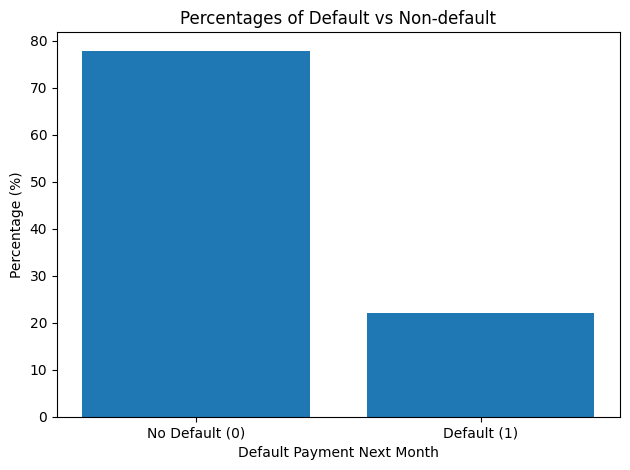

In [ ]:
# Plot percentages
plt.figure()
plt.bar(percentages.index.astype(str), percentages.values)
plt.title("Percentages of Default vs Non-default")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Percentage (%)")
plt.xticks([0,1], ["No Default (0)", "Default (1)"])
plt.tight_layout()
plt.show()

# Visualization

/tmp/ipython-input-1792914118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default_payment_next_month', data=df, palette='Set2')


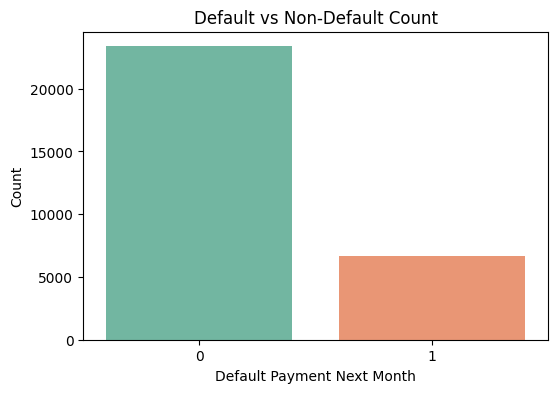

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='default_payment_next_month', data=df, palette='Set2')
plt.title("Default vs Non-Default Count")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Count")
plt.show()


## 2. Age Distribution by Default Status

Purpose: See how age varies between defaulters and non-defaulters.

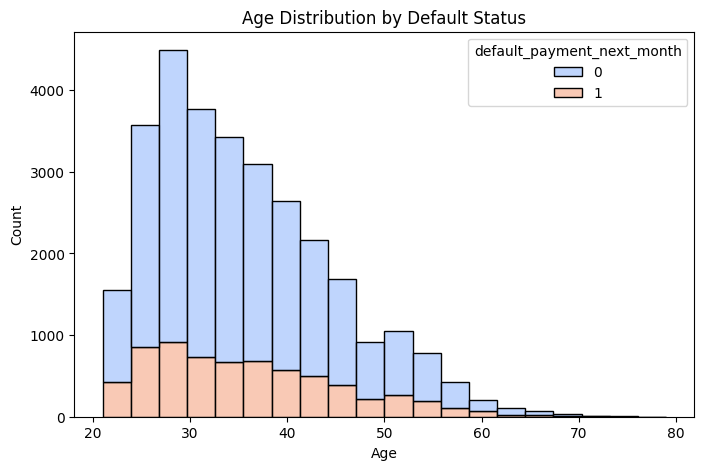

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='default_payment_next_month', multiple='stack', palette='coolwarm', bins=20)
plt.title("Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


# 3. Credit Limit vs Age (Colored by Default)

Purpose: See if credit limit and age together show a pattern in defaults.

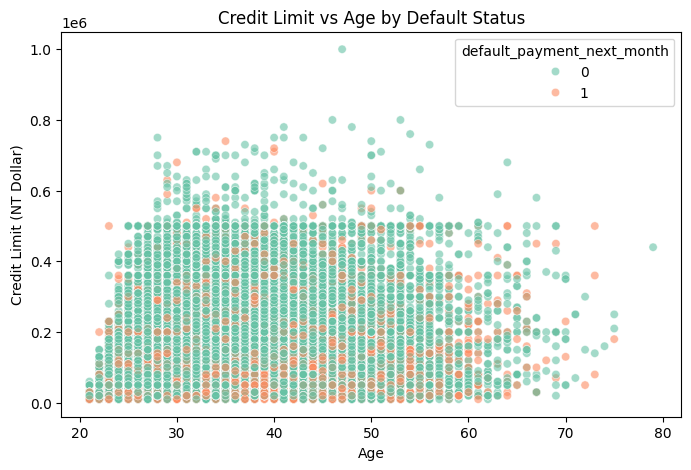

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='limit_bal', hue='default_payment_next_month', palette='Set2', alpha=0.6)
plt.title("Credit Limit vs Age by Default Status")
plt.xlabel("Age")
plt.ylabel("Credit Limit (NT Dollar)")
plt.show()


## 4. Payment History Heatmap (PAY_0 to PAY_6)

Purpose: See the correlation between past payment status and defaults.

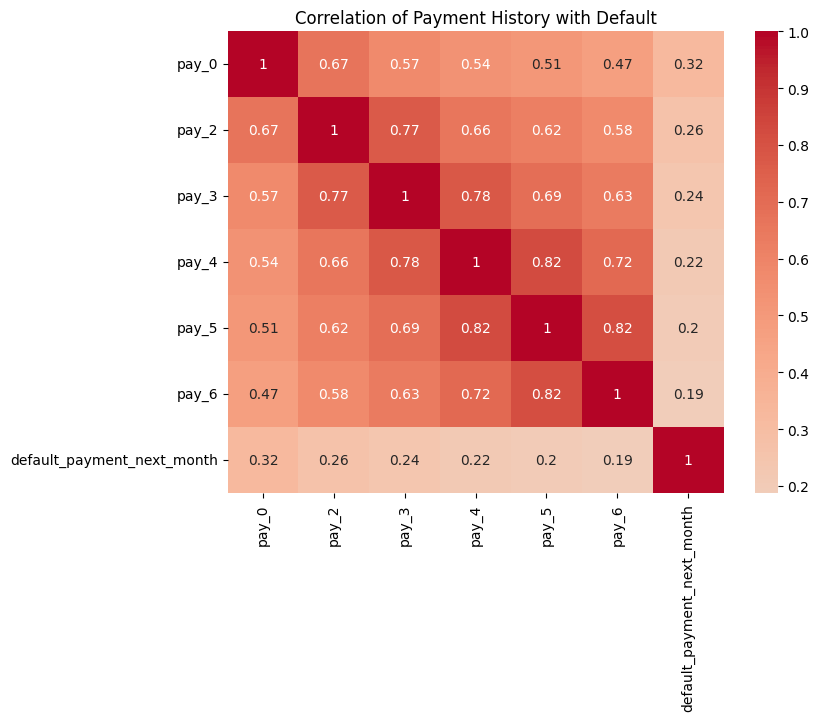

In [ ]:
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(8,6))
sns.heatmap(df[pay_cols + ['default_payment_next_month']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Payment History with Default")
plt.show()


## Encoding Categorical Features

In [ ]:
# --- 4. Categorical cleanup and encoding ---
df["education"] = df["education"].replace({0: 4, 5: 4, 6: 4})  # group unknowns
df["marriage"] = df["marriage"].replace({0: 3})  # unknown -> other

df = pd.get_dummies(df, columns=["sex", "education", "marriage"], drop_first=True, dtype=int)

# Splitting the data set

In [ ]:
# --- 4. Prepare features and target ---
X = df.drop(columns=[target, "id"])
y = df[target]

# --- 5. Train/test split (stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE On Training to Handle imbalance

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE


# --- 6. Handle imbalance on training set with SMOTE ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Scaling the Numerical Features

In [ ]:
# --- 7. Scaling ---
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# **Train Logistic Regression**

In [ ]:

# --- 8. Train logistic regression ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000)

## Evaluate the Model Performance

In [ ]:

# --- 9. Evaluate ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))


Classification Report:
               precision    recall  f1-score   support

           0     0.8457    0.7516    0.7958      4673
           1     0.3714    0.5170    0.4323      1327

    accuracy                         0.6997      6000
   macro avg     0.6085    0.6343    0.6140      6000
weighted avg     0.7408    0.6997    0.7154      6000

ROC-AUC: 0.6805


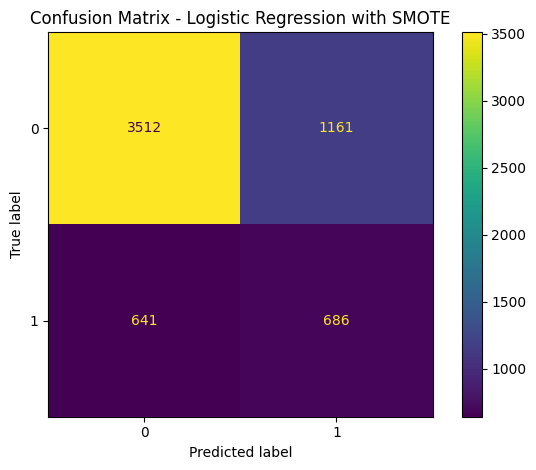

In [ ]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression with SMOTE"); plt.tight_layout()
plt.show()


# Train Decision Tree and Random Forest Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Feature Engineering

In [ ]:
# --- 2. Implicit feature engineering (auto) ---
# debt_ratio: latest bill relative to credit limit
df["debt_ratio"] = df["bill_amt1"] / df["limit_bal"]

# average bill and average payment over 6 months
df["avg_bill"] = df[
    ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]
].mean(axis=1)
df["avg_payment"] = df[
    ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]
].mean(axis=1)

# total pay vs total bill ratio
total_bill = df[
    ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]
].sum(axis=1)
total_pay = df[
    ["pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]
].sum(axis=1)
df["payment_to_bill_ratio"] = total_pay / total_bill


In [ ]:
df.head(3)

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,debt_ratio,avg_bill,avg_payment,payment_to_bill_ratio,sex_2,education_2,education_3,education_4,marriage_2,marriage_3
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0.195650,1284.000000,114.833333,0.089434,True,True,False,False,False,False
1,2,120000,26,-1,2,0,0,0,2,2682,...,0.022350,2846.166667,833.333333,0.292791,True,True,False,False,True,False
2,3,90000,34,0,0,0,0,0,0,29239,...,0.324878,16942.166667,1836.333333,0.108388,True,True,False,False,True,False


In [ ]:
# Clean infinities / NaNs from division
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[["debt_ratio", "avg_bill", "avg_payment", "payment_to_bill_ratio"]] = (
    df[["debt_ratio", "avg_bill", "avg_payment", "payment_to_bill_ratio"]].fillna(0)
)

In [ ]:

# --- 3. Show the new engineered features (can log or display to user) ---
print("Sample engineered features:")
print(df[["debt_ratio", "avg_bill", "avg_payment", "payment_to_bill_ratio"]].head())


Sample engineered features:
   debt_ratio      avg_bill  avg_payment  payment_to_bill_ratio
0    0.195650   1284.000000   114.833333               0.089434
1    0.022350   2846.166667   833.333333               0.292791
2    0.324878  16942.166667  1836.333333               0.108388
3    0.939800  38555.666667  1398.000000               0.036259
4    0.172340  18223.166667  9841.500000               0.540054


In [ ]:
df

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,sex_2,education_2,education_3,education_4,marriage_2,marriage_3,debt_ratio,avg_bill,avg_payment,payment_to_bill_ratio
0,1,20000,24,2,2,-1,-1,-2,-2,3913,...,1,1,0,0,0,0,0.195650,1284.000000,114.833333,0.089434
1,2,120000,26,-1,2,0,0,0,2,2682,...,1,1,0,0,1,0,0.022350,2846.166667,833.333333,0.292791
2,3,90000,34,0,0,0,0,0,0,29239,...,1,1,0,0,1,0,0.324878,16942.166667,1836.333333,0.108388
3,4,50000,37,0,0,0,0,0,0,46990,...,1,1,0,0,0,0,0.939800,38555.666667,1398.000000,0.036259
4,5,50000,57,-1,0,-1,0,0,0,8617,...,0,1,0,0,0,0,0.172340,18223.166667,9841.500000,0.540054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,39,0,0,0,0,0,0,188948,...,0,0,1,0,0,0,0.858855,120891.500000,7091.666667,0.058661
29996,29997,150000,43,-1,-1,-1,-1,0,0,1683,...,0,0,1,0,1,0,0.011220,3530.333333,2415.000000,0.684071
29997,29998,30000,37,4,3,2,-1,0,0,3565,...,0,1,0,0,1,0,0.118833,11749.333333,5216.666667,0.443997
29998,29999,80000,41,1,-1,0,0,0,-1,-1645,...,0,0,1,0,0,0,-0.020563,44435.166667,24530.166667,0.552044


In [ ]:
# --- 5. Prepare X and y ---
X = df.drop(columns=[target, "id"])
y = df[target]

# --- 6. Train/test split stratified ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# --- 7. (Optional) scale numerics for tree models it's not required but helps if later using mixed models ---
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


--- Decision Tree ---
ROC-AUC: 0.7617
              precision    recall  f1-score   support

           0     0.8676    0.8286    0.8476      4673
           1     0.4789    0.5546    0.5140      1327

    accuracy                         0.7680      6000
   macro avg     0.6732    0.6916    0.6808      6000
weighted avg     0.7816    0.7680    0.7738      6000



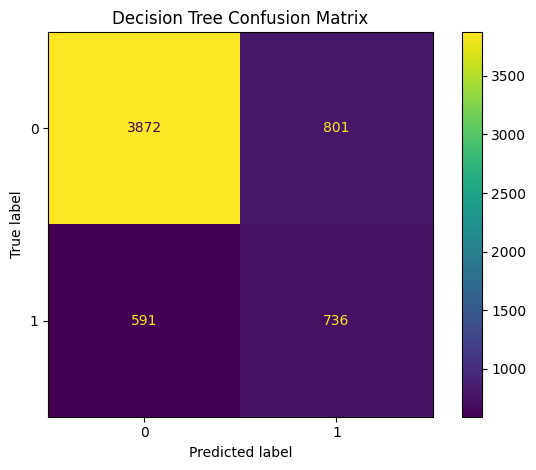

In [ ]:
# --- 8. Decision Tree baseline with class weight ---
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42, max_depth=5)  # limit depth to reduce overfitting
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]
print("\n--- Decision Tree ---")
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_dt), 4))
print(classification_report(y_test, y_pred_dt, digits=4))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()


## Random Forest with class weight


--- Random Forest ---
ROC-AUC: 0.7569
              precision    recall  f1-score   support

           0     0.8352    0.9497    0.8888      4673
           1     0.6574    0.3399    0.4481      1327

    accuracy                         0.8148      6000
   macro avg     0.7463    0.6448    0.6684      6000
weighted avg     0.7958    0.8148    0.7913      6000



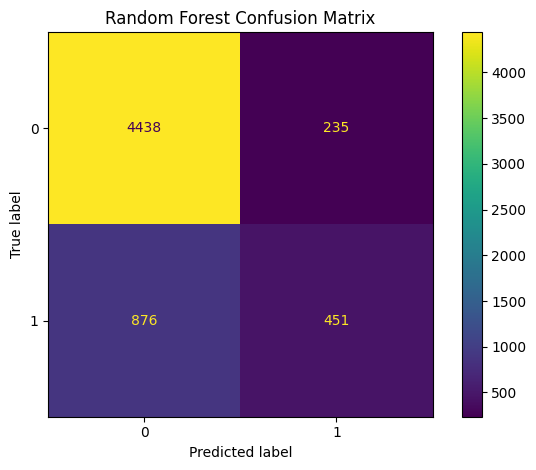

In [ ]:
# --- 9. Random Forest with class weight ---
rf = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
print("\n--- Random Forest ---")
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))
print(classification_report(y_test, y_pred_rf, digits=4))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# --- 10. Feature importance from Random Forest (to decide if drop/use) ---
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features by importance (RF):")
print(importances.head(10))


Top 10 features by importance (RF):
pay_0                    0.095489
debt_ratio               0.056150
age                      0.052710
avg_payment              0.051546
limit_bal                0.049374
payment_to_bill_ratio    0.048034
avg_bill                 0.043218
bill_amt1                0.043217
pay_amt2                 0.040335
pay_2                    0.040254
dtype: float64


In [ ]:
# --- 3. Train Random Forest ---
rf = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- 4. Baseline evaluation ---
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)
print("\n--- Random Forest (default threshold 0.5) ---")
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))
print(classification_report(y_test, y_pred_rf, digits=4))

# confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

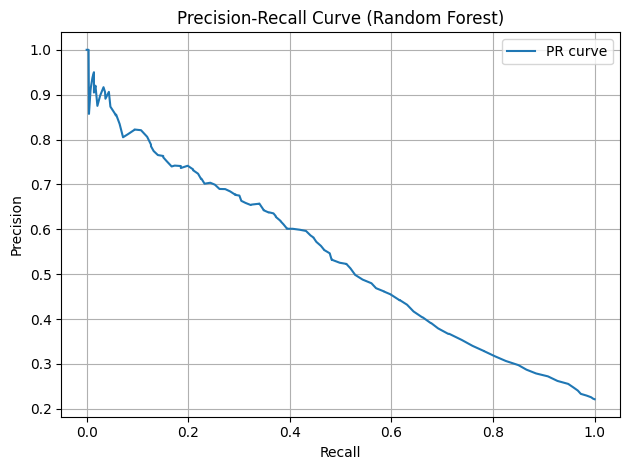

In [ ]:
# --- 5. Threshold tuning to target recall 0.45–0.50 ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

# plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Random Forest)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# search thresholds giving recall between 0.45 and 0.50, pick one with highest precision
target_min, target_max = 0.45, 0.50
candidates = []
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):  # last precision point has no threshold
    if target_min <= r <= target_max:
        candidates.append((r, p, t))
if candidates:
    # choose candidate with max precision in range
    best_candidate = max(candidates, key=lambda x: x[1])
    tuned_thresh = best_candidate[2]
    chosen_recall = best_candidate[0]
    chosen_precision = best_candidate[1]
else:
    # fallback: closest recall >= target_min
    idx = np.argmax(recall >= target_min)
    tuned_thresh = thresholds[idx] if idx < len(thresholds) else 0.5
    chosen_recall = recall[idx]
    chosen_precision = precision[idx]

print(f"\nSelected threshold for recall ~[{target_min},{target_max}]: {tuned_thresh:.3f}")
print(f"Corresponding recall: {chosen_recall:.4f}, precision: {chosen_precision:.4f}")




Selected threshold for recall ~[0.45,0.5]: 0.380
Corresponding recall: 0.4521, precision: 0.5720


In [ ]:
# apply tuned threshold
y_pred_tuned = (y_proba_rf >= tuned_thresh).astype(int)
print("\n--- Classification report at tuned threshold ---")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("Recall:", recall_score(y_test, y_pred_tuned))


--- Classification report at tuned threshold ---
              precision    recall  f1-score   support

           0     0.8532    0.9039    0.8778      4673
           1     0.5720    0.4521    0.5051      1327

    accuracy                         0.8040      6000
   macro avg     0.7126    0.6780    0.6914      6000
weighted avg     0.7910    0.8040    0.7954      6000

Recall: 0.45214770158251694


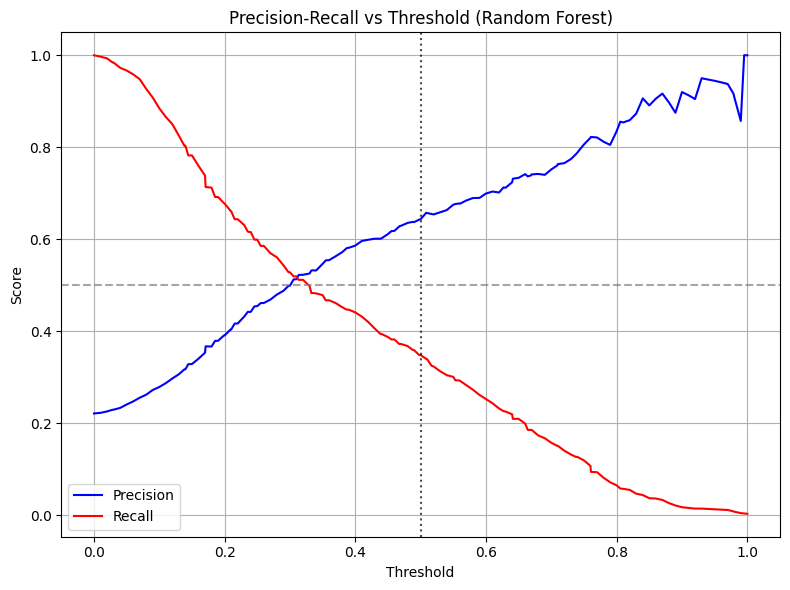

Sample Threshold, Precision, Recall:
Threshold: 0.000, Precision: 0.221, Recall: 1.000
Threshold: 0.310, Precision: 0.513, Recall: 0.519
Threshold: 0.641, Precision: 0.732, Recall: 0.209


In [ ]:
# from sklearn.metrics import precision_recall_curve
# import matplotlib.pyplot as plt
# import numpy as np

# # Compute precision, recall, thresholds
# precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

# Plot precision and recall against threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.7)  # precision threshold line
plt.axvline(0.5, color='black', linestyle=':', alpha=0.7) # default threshold line

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally: print some points for manual inspection
points = zip(thresholds[::50], precision[::50], recall[::50])  # sample every 50th point
print("Sample Threshold, Precision, Recall:")
for t, p, r in points:
    print(f"Threshold: {t:.3f}, Precision: {p:.3f}, Recall: {r:.3f}")


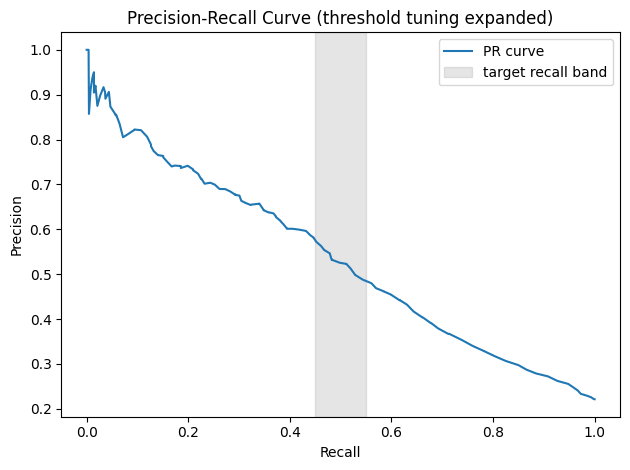


Selected threshold for recall in [0.5,0.6]: 0.320
Recall: 0.5117, Precision: 0.5227


In [ ]:

# Search thresholds with recall in [0.45, 0.55]
target_min, target_max = 0.50, 0.60
candidates = []
for p, r, t in zip(precision[:-1], recall[:-1], thresholds):  # last precision point has no threshold
    if target_min <= r <= target_max:
        candidates.append((r, p, t))

if candidates:
    # among those, prefer ones with precision >= 0.5, else take highest precision
    filtered = [c for c in candidates if c[1] >= 0.5]
    if filtered:
        best = max(filtered, key=lambda x: x[1])
    else:
        best = max(candidates, key=lambda x: x[1])
    chosen_recall, chosen_precision, tuned_thresh = best
else:
    # fallback: closest recall >= target_min
    idx = np.argmax(recall >= target_min)
    tuned_thresh = thresholds[idx] if idx < len(thresholds) else 0.5
    chosen_recall = recall[idx]
    chosen_precision = precision[idx]

print(f"\nSelected threshold for recall in [{target_min},{target_max}]: {tuned_thresh:.3f}")
print(f"Recall: {chosen_recall:.4f}, Precision: {chosen_precision:.4f}")




In [ ]:
# Apply threshold and report

from sklearn.metrics import classification_report, recall_score

y_pred_tuned = (y_proba_rf >= tuned_thresh).astype(int)
print("\n--- Classification report at tuned threshold ---")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("Final recall:", recall_score(y_test, y_pred_tuned))


--- Classification report at tuned threshold ---
              precision    recall  f1-score   support

           0     0.8622    0.8673    0.8647      4673
           1     0.5227    0.5117    0.5171      1327

    accuracy                         0.7887      6000
   macro avg     0.6924    0.6895    0.6909      6000
weighted avg     0.7871    0.7887    0.7879      6000

Final recall: 0.5116804822908817


## save the model + scaler + threshold

In [ ]:
import joblib

# Save objects
joblib.dump(rf, "random_forest_model.joblib")
joblib.dump(scaler, "scaler.joblib")

# (Optional) If you’ve settled on a decision threshold, save it too
threshold = 0.32  # or whatever you choose
joblib.dump(threshold, "threshold.joblib")


['threshold.joblib']

# To load them back

In [ ]:
import joblib

rf_loaded = joblib.load("random_forest_model.joblib")
scaler_loaded = joblib.load("scaler.joblib")
threshold_loaded = joblib.load("threshold.joblib")

# Example usage on new data (assuming same preprocessing):
X_new_scaled = scaler_loaded.transform(X_new)  # X_new is prepared feature matrix
proba = rf_loaded.predict_proba(X_new_scaled)[:, 1]
y_pred = (proba >= threshold_loaded).astype(int)


# Downloads

In [ ]:
from google.colab import files
files.download("random_forest_model.joblib")
files.download("scaler.joblib")
files.download("threshold.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

# Check size in bytes → convert to MB
size_bytes = os.path.getsize("random_forest_model.joblib")
size_mb = size_bytes / (1024 * 1024)

print(f"Model file size: {size_mb:.2f} MB")


Model file size: 55.31 MB


In [ ]:
print(f"Scaler file size: {os.path.getsize('scaler.joblib') / (1024*1024):} MB")


Scaler file size: 0.0018377304077148438 MB
